Imports
-------

In [1]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
import seaborn as sns

import numpy as np
import pandas as pd
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import preprocessing
from sklearn.cross_validation import cross_val_score

/Users/shiv/anaconda/envs/coding-env/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/shiv/anaconda/envs/coding-env/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Data Loading
------------

In [2]:
base_folder = ''
data = pd.read_csv(base_folder + 'train.csv')

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Categorical/String variables:
* Name
* Sex
* Ticket
* Cabin
* Embarked

## Numerical variables:
* PassengerId
* Pclass
* Age
* SibSp
* Parch
* Fare

In [4]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* From all the numerical variables Age has missing values in training set

# Sensible Value Imputation

* There are many ways for filling missing values, just filling in the median of the values for now.

In [5]:
# filled the empty age with median value of age
data['Age'].fillna(data['Age'].median(), inplace=True)

# Explore Data

### Sex versus survival

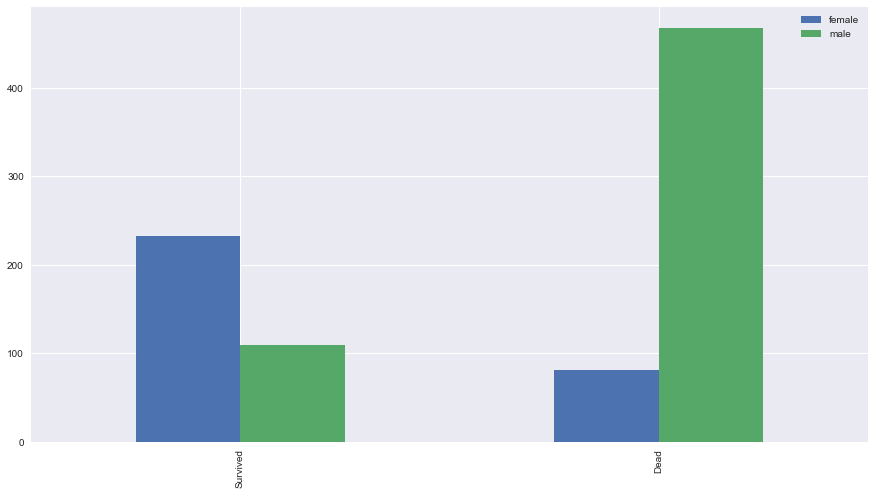

In [6]:
survived_sex = data[data['Survived']==1]['Sex'].value_counts()
dead_sex = data[data['Survived']==0]['Sex'].value_counts()
#plot the survived male , female and dead male,female
df = pd.DataFrame([survived_sex,dead_sex])
df.index = ['Survived','Dead']
df.plot(kind='bar', figsize=(15,8))

* Can be clearly seen from the above plot, males did not stand much of a chance :)
* % of male survival seems much less than female survival

### Age versus survival

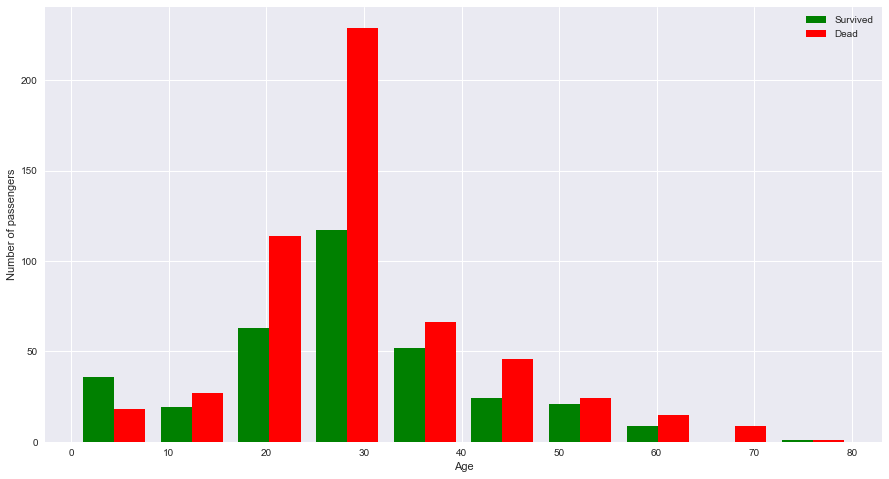

In [7]:
# dead and survived based on age of people
figure = plt.figure(figsize=(15,8))
plt.hist([data[data['Survived']==1]['Age'],data[data['Survived']==0]['Age']], color = ['g','r'],
         bins = 10,label = ['Survived','Dead'])
plt.xlabel('Age')
plt.ylabel('Number of passengers')
plt.legend()

* Those in the range 20-40 are more likely to be dead.
* Those in the range 70-80 are almost always dead.
* 0-20 there is not much diff i think
* Making these as features would be a good idea?

### Fare versus survival

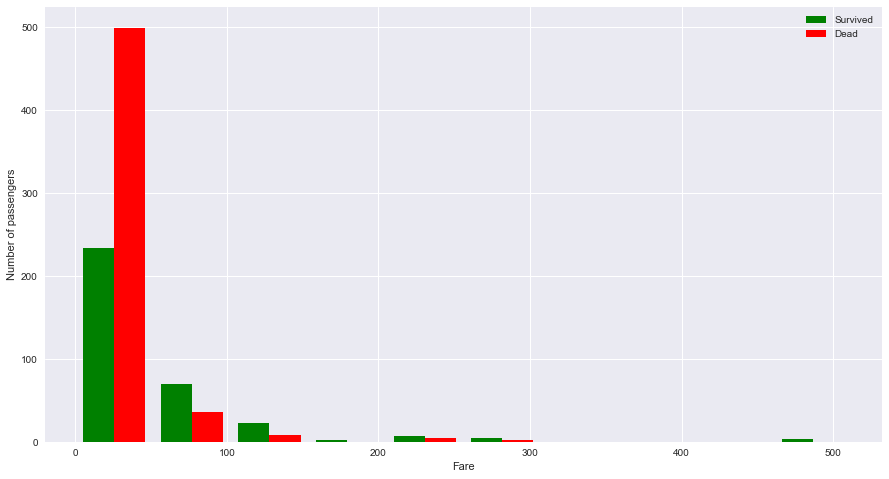

In [8]:
# plotting number of survivors based on the fare they gave
figure = plt.figure(figsize=(15,8))
plt.hist([data[data['Survived']==1]['Fare'],data[data['Survived']==0]['Fare']], color = ['g','r'],
         bins = 10,label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend()

* Not exactly sure whether making <50 a feature will be a good idea? Although people less than 50 have high death rate!!
* But over the complete data set we cannot say anything from the fare alone

### Age versus Fare
* Survived
* Not Survied

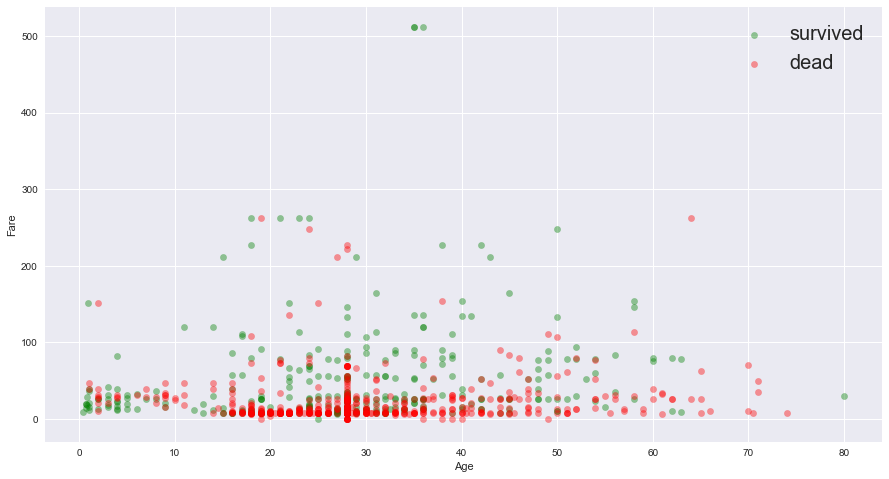

In [15]:
plt.figure(figsize=(15,8))
ax = plt.subplot()
ax.scatter(data[data['Survived']==1]['Age'],data[data['Survived']==1]['Fare'],c='green',s=40, alpha=0.4)
ax.scatter(data[data['Survived']==0]['Age'],data[data['Survived']==0]['Fare'],c='red',s=40, alpha=0.4)
ax.set_xlabel('Age')
ax.set_ylabel('Fare')
ax.legend(('survived','dead'),scatterpoints=1,loc='upper right',fontsize=20,)

* Now i know that individually age between 20-40 are killed more.
* Also i know individually those with lower fares are also killed more.

### Pclass versus survival

([array([ 136.,    0.,    0.,    0.,    0.,   87.,    0.,    0.,    0.,  119.]),
  array([  80.,    0.,    0.,    0.,    0.,   97.,    0.,    0.,    0.,  372.])],
 array([ 1. ,  1.2,  1.4,  1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ]),
 <a list of 2 Lists of Patches objects>)

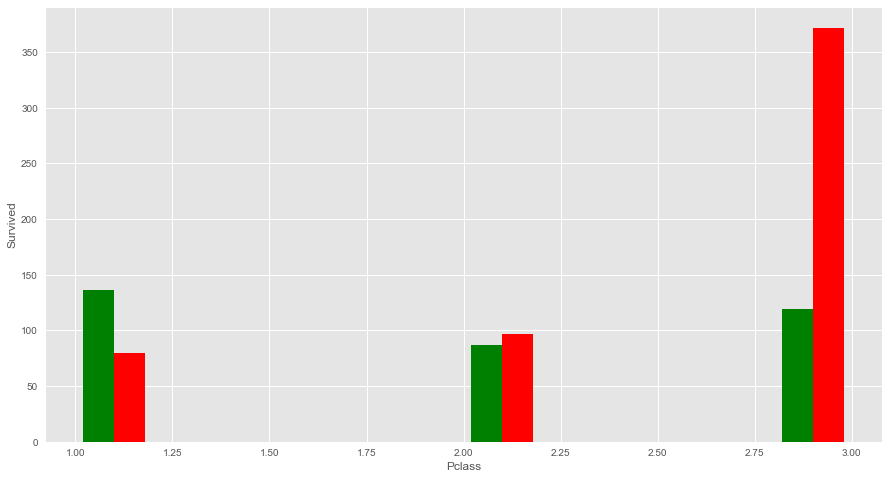

In [12]:
plt.figure(figsize=(15,8))
ax = plt.subplot()
ax.set_ylabel('Survived')
ax.set_xlabel('Pclass')
ax.hist([data[data['Survived']==1]['Pclass'],data[data['Survived']==0]['Pclass']],color = ['g','r'],)

* So from the above we see pclass3 is mostly dead. Class might correspond to the status here!?
* That we can check from the fare they paid for a particular class!

### Pclass versus fare

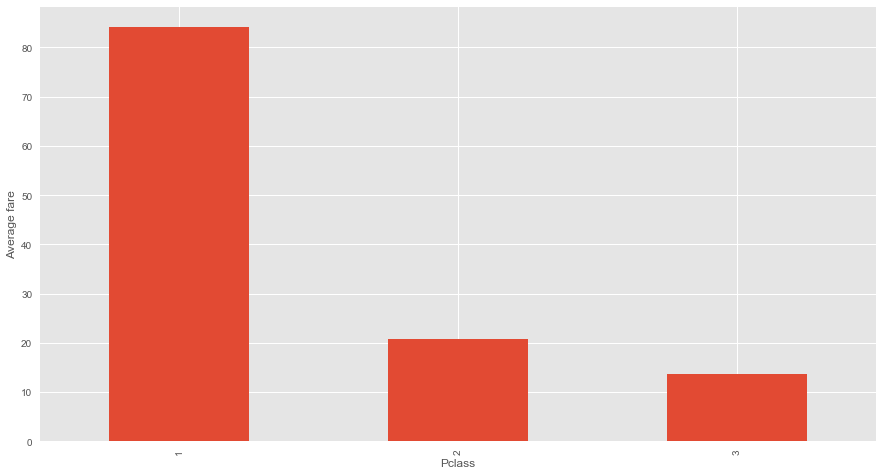

In [13]:
# Plotting how fares versus pclass goes?
ax = plt.subplot()
ax.set_ylabel('Average fare')
# we are plotting the mean cause the mean would show overall co-relation 
#rather than indivisual data points which may be unclear
data.groupby('Pclass').mean()['Fare'].plot(kind='bar',figsize=(15,8), ax = ax)

### Embarkment versus survival

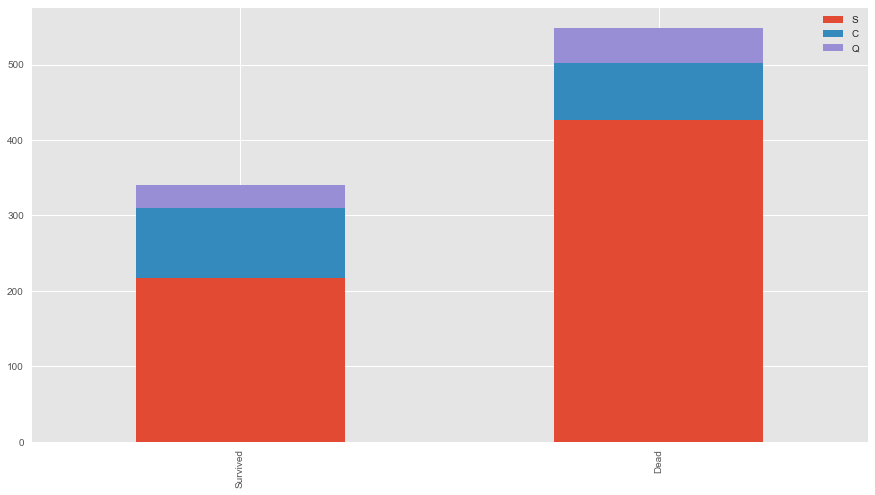

In [14]:
survived_embark = data[data['Survived']==1]['Embarked'].value_counts()
dead_embark = data[data['Survived']==0]['Embarked'].value_counts()
df = pd.DataFrame([survived_embark,dead_embark])
df.index = ['Survived','Dead']
df.plot(kind='bar',stacked=True, figsize=(15,8))

# Feature Engineering

In [15]:
# Combining both the test and trainig data so that all the manipulations which are done
# happen on both the data sets.
# Also if test set has any missing values, it will easily come to notice here
def get_combined_data():
    train = pd.read_csv(base_folder + 'train.csv')
    test = pd.read_csv(base_folder + 'test.csv')
    # extracting and then removing the targets from the training data 
    targets = train.Survived
    train.drop('Survived',1,inplace=True)
    
    combined = train.append(test)
    combined.reset_index(inplace=True)
    combined.drop('index',inplace=True,axis=1)
    return combined
combined = get_combined_data()

In [16]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 112.6+ KB


* We can see some variables have missing values
  * Fare
  * Cabin
  * Embarked
  * Age

# Sensible Value Imputation

* Filling missing values in both the test and the train data from those calculated from the training data

In [17]:
combined.Cabin.fillna('U',inplace=True)
combined.Embarked.fillna('S',inplace=True)
combined.Fare.fillna(data.Fare.mean(),inplace=True)
combined.Age.fillna(data.Age.median(), inplace=True)

### Family Size feature

In [18]:
# The size of families (including the passenger)
combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1
# Introducing other features based on the family size
combined['Alone'] = combined['FamilySize'].map(lambda s : 1 if s == 1 else 0)
combined['Small'] = combined['FamilySize'].map(lambda s : 1 if 2<=s<=4 else 0)
combined['Large'] = combined['FamilySize'].map(lambda s : 1 if 5<=s else 0)

([array([ 163.,   89.,   59.,   21.,    3.,    3.,    4.,    0.,    0.,    0.]),
  array([ 374.,   72.,   43.,    8.,   12.,   19.,    8.,    6.,    0.,    7.])],
 array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.]),
 <a list of 2 Lists of Patches objects>)

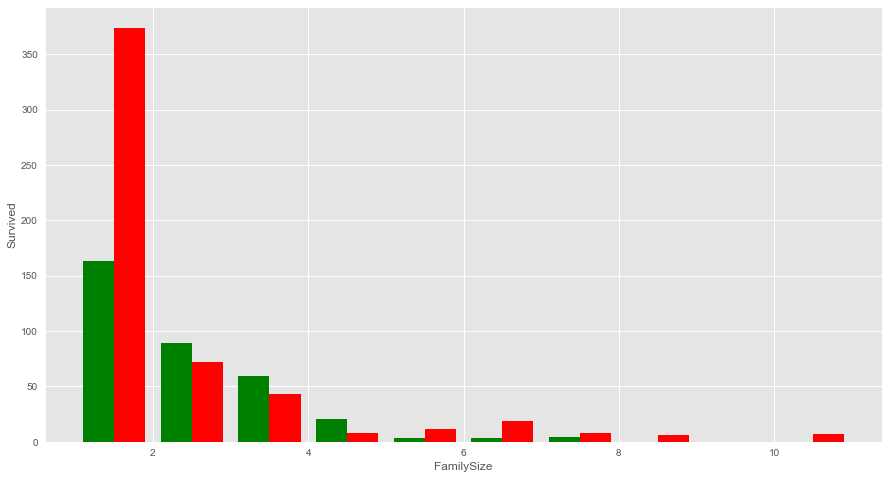

In [19]:
# The size of families on the training set
data['FamilySize'] = data['Parch'] + data['SibSp'] + 1
plt.figure(figsize=(15,8))
ax = plt.subplot()
ax.set_ylabel('Survived')
ax.set_xlabel('FamilySize')
ax.hist([data[data['Survived']==1]['FamilySize'],data[data['Survived']==0]['FamilySize']],color = ['g','r'],)

* Seems like.. if you are alone: you are dead!

### Title feature

In [20]:
if 'Title' not in combined.columns:
    combined['Title'] = combined['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    Title_Dictionary = {
                        "Capt":       "Officer",
                        "Col":        "Officer",
                        "Major":      "Officer",
                        "Jonkheer":   "Royalty",
                        "Don":        "Royalty",
                        "Sir" :       "Royalty",
                        "Dr":         "Officer",
                        "Rev":        "Officer",
                        "the Countess":"Royalty",
                        "Dona":       "Royalty",
                        "Mme":        "Mrs",
                        "Mlle":       "Miss",
                        "Ms":         "Mrs",
                        "Mr" :        "Mr",
                        "Mrs" :       "Mrs",
                        "Miss" :      "Miss",
                        "Master" :    "Master",
                        "Lady" :      "Royalty"

                        }
    combined['Title'] = combined.Title.map(Title_Dictionary)
    combined.drop('Name',axis=1,inplace=True)
    titles_dummies = pd.get_dummies(combined['Title'],prefix='Title')
    combined.drop('Title',axis=1,inplace=True)
    combined = pd.concat([combined,titles_dummies],axis=1)

In [21]:
data['Title'] = data['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
data['Title'] = data.Title.map(Title_Dictionary)
data = pd.concat([data,pd.get_dummies(data['Title'],prefix='Title')],axis=1)

([array([ 337.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    5.]),
  array([ 536.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   13.])],
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 2 Lists of Patches objects>)

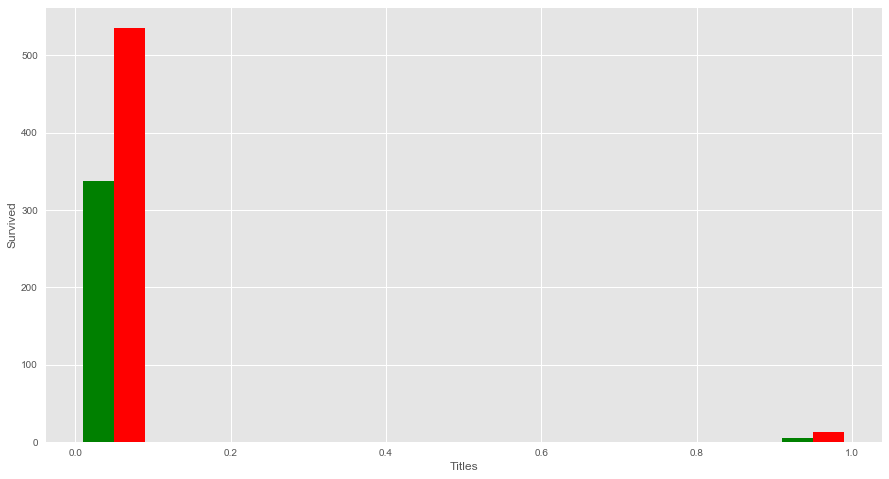

In [22]:
plt.figure(figsize=(15,8))
ax = plt.subplot()
ax.set_ylabel('Survived')
ax.set_xlabel('Titles')
ax.hist([data[data['Survived']==1]['Title_Officer'],
         data[data['Survived']==0]['Title_Officer']
        ],color = ['g','r'],)

* It can be seen that people with better titles survived more! This may be a good feature.

### Adding some categorical features

In [23]:
# new columns m planning to create are age ranges
# 10-20, 20-30 something like that
combined['20-40'] = combined['Age'].apply(lambda x: 1 if x>=20 and x<=40 else 0)
combined['70-80'] = combined['Age'].apply(lambda x: 1 if x>=70 and x<=80 else 0)
combined['below-80'] = combined['Fare'].apply(lambda x: 1 if x<80 else 0)

### Categorical to one-hot encoding

In [24]:
def get_one_hot_encoding(dt, features):
    for feature in features:
        if feature in dt.columns:
            dummies = pd.get_dummies(dt[feature],prefix=feature)
            dt = pd.concat([dt,dummies],axis=1)
    return dt

In [25]:
combined = get_one_hot_encoding(combined,['Embarked','Cabin','Pclass','Embarked','Title'])
combined['Sex'] = combined['Sex'].map({'male':0,'female':1})
combined.drop(['Embarked','Cabin','Pclass','Embarked','Title'],inplace=True,axis=1)

### Ticket feature extraction

In [26]:
def cleanTicket(ticket):
        ticket = ticket.replace('.','')
        ticket = ticket.replace('/','')
        ticket = ticket.split()
        ticket = map(lambda t : t.strip() , ticket)
        ticket = filter(lambda t : not t.isdigit(), ticket)
        ticket = list(ticket)
        if (len(ticket)) > 0:
            return ticket[0]
        else: 
            return 'XXX'

combined['Ticket'] = combined['Ticket'].map(cleanTicket)

In [27]:
combined = get_one_hot_encoding(combined,'Ticket')
combined.drop('Ticket',axis=1,inplace=True)

# Normalise

In [28]:
columns = combined.columns
combined_new = pd.DataFrame(preprocessing.normalize(combined, axis=0, copy=True), columns=columns)
combined_new['PassengerId'] = combined['PassengerId']
combined = combined_new

In [29]:
combined.head()

,PassengerId,Sex,Age,SibSp,Parch,Fare,FamilySize,Alone,Small,Large,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,20-40,70-80,below-80,Embarked_C,Embarked_Q,Embarked_S,Cabin_A10,Cabin_A11,Cabin_A14,Cabin_A16,Cabin_A18,Cabin_A19,Cabin_A20,Cabin_A21,Cabin_A23,Cabin_A24,Cabin_A26,Cabin_A29,Cabin_A31,Cabin_A32,Cabin_A34,Cabin_A36,Cabin_A5,Cabin_A6,Cabin_A7,Cabin_A9,Cabin_B10,Cabin_B101,Cabin_B102,Cabin_B11,Cabin_B18,Cabin_B19,Cabin_B20,Cabin_B22,...,Cabin_D56,Cabin_D6,Cabin_D7,Cabin_D9,Cabin_E10,Cabin_E101,Cabin_E12,Cabin_E121,Cabin_E17,Cabin_E24,Cabin_E25,Cabin_E31,Cabin_E33,Cabin_E34,Cabin_E36,Cabin_E38,Cabin_E39 E41,Cabin_E40,Cabin_E44,Cabin_E45,Cabin_E46,Cabin_E49,Cabin_E50,Cabin_E52,Cabin_E58,Cabin_E60,Cabin_E63,Cabin_E67,Cabin_E68,Cabin_E77,Cabin_E8,Cabin_F,Cabin_F E46,Cabin_F E57,Cabin_F E69,Cabin_F G63,Cabin_F G73,Cabin_F2,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_T,Cabin_U,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0.000000,0.018884,0.023939,0.0,0.003258,0.022465,0.000000,0.047836,0.0,0.0,0.00000,0.036346,0.000000,0.0,0.0,0.034159,0.0,0.028964,0.000000,0.0,0.033041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031404,0.000000,0.0,0.037556,0.000000,0.0,0.033041
1,2,0.046324,0.032618,0.023939,0.0,0.032031,0.022465,0.000000,0.047836,0.0,0.0,0.00000,0.000000,0.070711,0.0,0.0,0.034159,0.0,0.028964,0.060858,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.055641,0.0,0.000000,0.060858,0.0,0.000000
2,3,0.046324,0.022317,0.000000,0.0,0.003561,0.011232,0.035578,0.000000,0.0,0.0,0.06178,0.000000,0.000000,0.0,0.0,0.034159,0.0,0.028964,0.000000,0.0,0.033041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031404,0.000000,0.0,0.037556,0.000000,0.0,0.033041
3,4,0.046324,0.030043,0.023939,0.0,0.023861,0.022465,0.000000,0.047836,0.0,0.0,0.00000,0.000000,0.070711,0.0,0.0,0.034159,0.0,0.028964,0.000000,0.0,0.033041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.055641,0.0,0.000000,0.000000,0.0,0.033041
4,5,0.000000,0.030043,0.000000,0.0,0.003617,0.011232,0.035578,0.000000,0.0,0.0,0.00000,0.036346,0.000000,0.0,0.0,0.034159,0.0,0.028964,0.000000,0.0,0.033041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031404,0.000000,0.0,0.037556,0.000000,0.0,0.033041


# Recover

In [30]:
train0 = pd.read_csv(base_folder + 'train.csv')
targets = train0.Survived
train = combined[0:891]
test = combined[891:]

# Feature Selection

In [31]:
clf = ExtraTreesClassifier(n_estimators=200)
clf = clf.fit(train, targets)
features = pd.DataFrame()
features['feature'] = train.columns
features['importance'] = clf.feature_importances_
cols =  features.sort(['importance'],ascending=False)['feature']
model = SelectFromModel(clf, prefit=True)
train_new = model.transform(train)
test_new = model.transform(test)

/Users/shiv/anaconda/envs/coding-env/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [32]:
cols

0            PassengerId
5                   Fare
2                    Age
12              Title_Mr
1                    Sex
11            Title_Miss
13             Title_Mrs
211             Pclass_3
208              Cabin_U
209             Pclass_1
8                  Small
6             FamilySize
16                 20-40
3                  SibSp
4                  Parch
210             Pclass_2
9                  Large
10          Title_Master
18              below-80
7                  Alone
19            Embarked_C
21            Embarked_S
214           Embarked_S
14         Title_Officer
212           Embarked_C
174            Cabin_E24
175            Cabin_E25
114            Cabin_C52
213           Embarked_Q
20            Embarked_Q
101        Cabin_C22 C26
171            Cabin_E12
87            Cabin_C106
159            Cabin_D45
173            Cabin_E17
39              Cabin_A6
17                 70-80
169            Cabin_E10
95            Cabin_C126
165            Cabin_D56


In [33]:
train_new.shape

(891, 25)

# Models

In [ ]:
forest = RandomForestClassifier(max_features='sqrt')

parameter_grid = {
                 'max_depth' : [4,5,6,7,8,9],
                 'n_estimators': [100, 200,210,240,250],
                 'criterion': ['gini','entropy']
                 }

cross_validation = StratifiedKFold(targets, n_folds=5)

grid_search = GridSearchCV(forest,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(train_new, targets)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.833894500561
Best parameters: {'n_estimators': 240, 'criterion': 'gini', 'max_depth': 4}


In [ ]:
ext = ExtraTreesClassifier()

parameter_grid = {
                 'max_depth' : [4,5,6,7,8,9],
                 'n_estimators': [100, 200,210,240,250],
                 'criterion': ['gini','entropy']
                 }

cross_validation = StratifiedKFold(targets, n_folds=5)

grid_search = GridSearchCV(ext,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(train_new, targets)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

In [ ]:
lr = LogisticRegression(penalty='l2')

parameter_grid = {
                 'tol' : [0.1,0.01,0.001,10,1],
                 'max_iter': [100, 200,210,240,250],
                 }

cross_validation = StratifiedKFold(targets, n_folds=5)

grid_search = GridSearchCV(lr,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(train_new, targets)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
adaboost = AdaBoostClassifier(n_estimators=100)

cross_validation = StratifiedKFold(targets, n_folds=5)
adaboost.fit(train_new, targets)

print('Best score: {}'.format(cross_val_score(adaboost,train_new,targets,cv=10)))

# Voting 

In [ ]:
from sklearn.ensemble import VotingClassifier
eclf1 = VotingClassifier(estimators=[
        ('rf', forest),('etc',ext),('lr', lr), ('adb', adaboost)], voting='soft',
                        weights=[2,1,1,1])
eclf1 = eclf1.fit(train_new, targets)
predictions=eclf1.predict(test_new)
predictions

test_predictions=eclf1.predict(test_new)
test_predictions=test_predictions.astype(int)

In [ ]:
test_predictions = eclf1.predict(test_new)
df_output = pd.DataFrame()
df_output['PassengerId'] = test['PassengerId']
df_output['Survived'] = test_predictions
df_output[['PassengerId','Survived']].to_csv('output.csv',index=False)

# Ensembling and Stacking

In [ ]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }


In [ ]:
NFOLDS = 5
kf = StratifiedKFold(targets,n_folds= NFOLDS)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        return self.clf.fit(x,y).feature_importances_

In [ ]:
# Create 5 objects that represent our 4 models
SEED=0

rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

### Out of fold predictions
* First of all.. enumerate(kf). What does this do?
* This function returns indices of the 90%train and 10%test set which it generated from each fold of the same training set data.
* Using that data we can split the overall training data itself in to traing and test set for each fold... and  then utilize it for generating our k fold results if required.

* calculates mean predicts over the i folds in the test set
* calculates predictions over all folds of the training set
* finally returns both the predictions

In [ ]:
def get_oof(clf, x_train, y_train, x_test):
    ntrain = train.shape[0]
    ntest = test.shape[0]
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        # get the training of fold number i from training set
        x_tr = train_new[train_index]
        # get the targets of fold i from training set
        y_tr = targets[train_index]
        # get the remaining 10% test set from the ith fold 
        x_te = train_new[test_index]

        # train the classifier on the training set
        clf.train(x_tr, y_tr)
        
        # store results of predictions over the ith test set at proper locations
        # oof_train will contain all the predictions over the test set once all n_fold iterations are over
        oof_train[test_index] = clf.predict(x_te)
        # over the complete test set classifier trained so far will predict
        # ith entry of oof_test_skf will contain predictions from classifier trained till ith fold
        oof_test_skf[i, :] = clf.predict(x_test)

    # calculate mean of all the predictions done in the i folds and store them as final results in oof_test
    oof_test[:] = oof_test_skf.mean(axis=0)
    # predictions on training set, mean predictions on the test set
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [ ]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, train_new, targets, test_new) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,train_new, targets, test_new) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, train_new, targets, test_new) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,train_new, targets, test_new) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,train_new, targets, test_new) # Support Vector Classifier

print("Training is complete")

### Feature Importances

In [ ]:
rf_feature = rf.feature_importances(train_new,targets)
et_feature = et.feature_importances(train_new, targets)
ada_feature = ada.feature_importances(train_new, targets)
gb_feature = gb.feature_importances(train_new,targets)

### Second Level Dataframe

In [ ]:
cols_new = cols.values[0:25]

In [ ]:
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols_new,
     'Random Forest feature importances': rf_feature,
     'Extra Trees  feature importances': et_feature,
      'AdaBoost feature importances': ada_feature,
    'Gradient Boost feature importances': gb_feature
    })

In [ ]:
# The final dataframe
feature_dataframe.head()

* stored the predictions on training set of various classifiers into flattened array

In [ ]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

### Visualise co-relation between classifiers
* It has been seen that, lesser the co-relation, better the predictions from second level predictor

In [ ]:
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Portland',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

### Setup level 2

In [ ]:
#converted into a single array of training set(891) X 4 columns(number of classifiers)
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

#### FYI
* x_train will contain predictions from all the classifiers
* features for training for decision tree below is predictions of various classifiers
* x_test contains the predictions on the test set 

### Stack predictor

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=10,max_features='sqrt').fit(x_train, targets)
predictions = clf.predict(x_test)

In [ ]:
# Just throw these to kaggle output :)
predictions

# Output!!

In [ ]:
%%bash
kg submit output.csv -c titanic -u sp4658@nyu.edu -p **** -m "voting classifier"

# Improvements

* A lot can be done in Missing Value Imputation
* Wanted to try blending and other cool stuff!!
* This is my first Kernel, i wanted to learn and try out many different stuff. Please advice with improvements.

# References
* [Blending][1]
* [Stacking][2]
* [Ensembling][3]
* [Voting][4]
* [Stacking/Ensembling guide][5]
* [Random Forest][6]
* Lot more of them....


  [1]: https://github.com/emanuele/kaggle_pbr/blob/master/blend.py
  [2]: http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice
  [3]: http://mlwave.com/kaggle-ensembling-guide/
  [4]: https://www.kaggle.com/poonaml/titanic/titanic-survival-prediction-end-to-end-ml-pipeline
  [5]: https://www.kaggle.com/shivendra91/titanic/introduction-to-ensembling-stacking-in-python/editnb
  [6]: https://www.kaggle.com/benhamner/titanic/random-forest-benchmark-r/code